<a href="https://colab.research.google.com/github/sofiarochinhauab/convolutional-network/blob/main/convolutionalnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of roads as clean or littered
### Sofia Rocha
### Jorge Machado

# Imports

In [ ]:
import os
import pandas as pd

import seaborn as sns
import cv2
import tensorflow as tf

#for the zip files
import zipfile

#for copy the images to a new path
import shutil

#for check if the image is ok or not
import imghdr

import numpy as np
import matplotlib.pyplot as plt

#for the deep model
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#for testing the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Using for data_argumentation. Generate images
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
#avoid OOM erros by setting GPU memory consumption growth
# this is important, because the GPU is more suitable and powerful to handle deep learning problems than the CPU

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# import the images


In [ ]:
#import json config in the kaggle profile for api
# for get the dataset, you need to access the kaggle account and get the api
# after that, you do the upload the json that you save when you get the api
#profile -> api -> token -> upload the json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jmfm1990","key":"dfdf5d804894e9863a7cf936277a0beb"}'}

In [ ]:
# create a new directory for the json file
# we need that fot load the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#import all the images
!kaggle datasets download -d faizalkarim/cleandirty-road-classification

 94% 67.0M/71.6M [00:02<00:00, 34.9MB/s]
100% 71.6M/71.6M [00:02<00:00, 35.3MB/s]


In [ ]:
#unzip all the files
zip_ref = zipfile.ZipFile('cleandirty-road-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

### Prepare the data


In [ ]:
#get all the images
path_images = '/content/files/Images/Images/'
img_names = os.listdir(path_images)

#the new paths for the selected data
!mkdir -p '/content/images/clean'
!mkdir -p '/content/images/dirty'

path_clean_image = '/content/images/clean/'
path_dirty_image = '/content/images/dirty/'


In this case, after obtaining the dataset, we will create two directories, one for each class we have, and we store each of these directories in a different path variable.
This is useful, because when we upload the images, it becomes easier to classify them and obtain targets

In the following code, we will obtain the full path to the images, and we use the cv2 function, from the OpenCV library, which will read the images in a specific path.
After that, we check if the image contains "clean" or "dirty", to add it to the respective path for the respective class.
Separe the images int two classes: clean and dirty

In [ ]:

for img_name in img_names:
    # full path to the image
    img_path = os.path.join(path_images, img_name)

    # load the image
    img = cv2.imread(img_path)

    # add the corresponding label to the list
    if 'clean' in img_name:
       shutil.copy(img_path, path_clean_image)
    elif "dirty" in img_name:
       shutil.copy(img_path, path_dirty_image)

See if the data is not corrupted - This process is very important as we are checking and eliminating corrupted files, so that these same files will not interfere with the performance of our network.


In [ ]:
#files formats that are allowed by tensor
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

#path with selected images
path = '/content/images/'


# check if the image is ok
# if not remove it
# not every image that have a extension 'jpeg' for example, is a jpeg file

for image_class in os.listdir(path):
  for image in os.listdir(os.path.join(path, image_class)):
    image_path = os.path.join(path, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)

      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
      print('Issue with image {}'.format(image_path))
      os.remove(image_path)


Image not in ext list /content/images/clean/clean_57.jpg
Image not in ext list /content/images/clean/clean_33.jpg
Image not in ext list /content/images/clean/clean_27.jpg
Image not in ext list /content/images/clean/clean_50.jpg
Image not in ext list /content/images/clean/clean_83.jpg
Image not in ext list /content/images/clean/clean_111.jpg
Image not in ext list /content/images/clean/clean_45.jpg
Image not in ext list /content/images/clean/clean_86.jpg
Image not in ext list /content/images/clean/clean_51.jpg
Image not in ext list /content/images/clean/clean_62.jpg
Image not in ext list /content/images/clean/clean_89.jpg
Image not in ext list /content/images/clean/clean_19.jpg
Image not in ext list /content/images/clean/clean_85.jpg
Image not in ext list /content/images/dirty/dirty_67.jpg
Image not in ext list /content/images/dirty/dirty_17.jpg
Image not in ext list /content/images/dirty/dirty_6.jpg
Image not in ext list /content/images/dirty/dirty_61.jpg
Image not in ext list /content/

Afte that check, we remove 29 images, because they are corrupted

### load the data

In this cell we are importing the images into a tf.data.Dataset object, which is an efficient data structure for dealing with datasets in tensorFlow. Each item in the dataset is a pair of tensors, where the first tensor contains the images and the second tensor contains the corresponding labels.
This also allows the use of several available functions to process the data.


In [ ]:
# Found 207 files belonging to 2 classes
data = tf.keras.utils.image_dataset_from_directory(path)

#if we not check all the images will be an error
# prepare the images for same size, color, etc
# size = 256x256 by default
# batch_size = 32 by default
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 207 files belonging to 2 classes.


In [ ]:
# we can see that all the images have a classification that we don't know yet but there is 0 and 1 classes
batch[1]

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

This code is a small example of the type of image we will be dealing with. We can see clean roads and roads full of trash

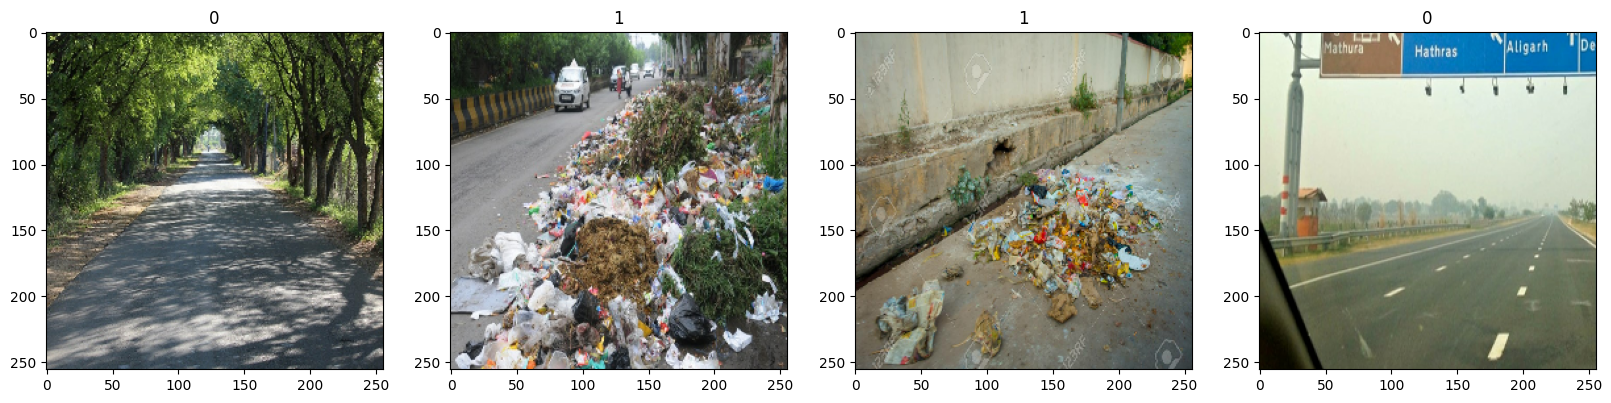

In [ ]:
#this is one way too see wich classes belong 0 and 1
# 1 is littered
# 0 is clean
# we can see that the images have the same size
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


# Preprocess Data
Divide all the data to get the smallest values

### This is for Testing wih greyScaler

This is for a test, we try creates a greyscaler images to check if the results is the same

In [ ]:
# Function to convert the image to grayscale
def to_grayscale(image, label):
    # Convert image to grayscale using cv2
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label


In [ ]:
# in this part we call the function to_grayScale, and save the result in the new tf.data.Dataset Object
data_greyscale = data.map(to_grayscale)

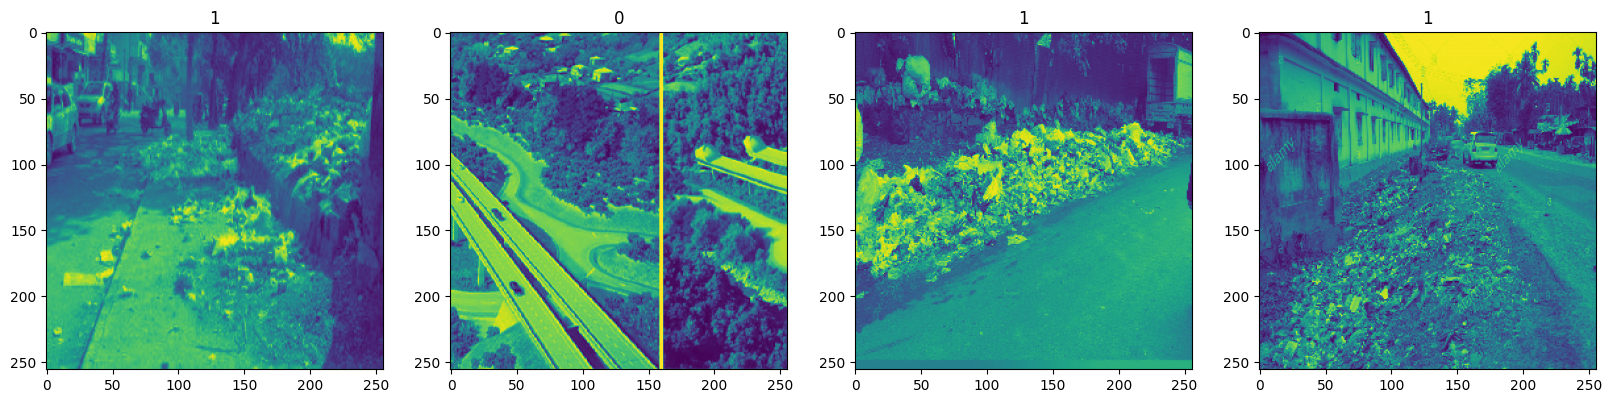

In [ ]:
# show some fotos in gray scaler
data_iterator_gray = data_greyscale.as_numpy_iterator()
batch_grey = data_iterator_gray.next()
# plot the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_grey[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch_grey[1][idx])

In [ ]:
# this is to use the images in grey_scale in the test
data_greyscale = data_greyscale.map(lambda x,y: (x/255, y))


Split the dataset, with the grey_scaler filtter, in train, validation and test

In [ ]:
tam_data_grey = len(data_greyscale) #== 7
train_size_grey = int(tam_data_grey*0.7) #4 batch for train
val_size_grey = int(tam_data_grey*0.2)+1 #1 batch for validation
test_size_grey = int(tam_data_grey*0.1)+1 #1 batch for testing

In [ ]:
#this will take the batches for each step of the model
train_grey = data_greyscale.take(train_size_grey)
val_grey = data_greyscale.skip(train_size_grey).take(val_size_grey)
test_grey = data_greyscale.skip(train_size_grey+val_size_grey).take(test_size_grey)


### Normalize the images pixels for the Normal train

Firstl, split the data in train, validation and test

In [ ]:
tam_data = len(data) #== 7
train_size = int(tam_data*0.7) #4 batch for train
val_size = int(tam_data*0.2)+1 #1 batch for validation
test_size = int(tam_data*0.1)+1 #1 batch for testing

In [ ]:
#this will take the batches for each step of the model
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Using a Data argumentation

Create a "data argumentation" function, which allows transformations to be applied to the images during training, such as rotation, zoom, and flip, to create artificial variations of the original images. The dataset remains the same size, only the training data undergoes this "transformation" during data training. Each sample of training data during training will have variations.

In [ ]:
#Data_argumentation
data_argumentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

Function to show the number of samples in training, validation and test data

In [ ]:
def cont_data_number(data, label):
# initialize the counters  num_images = 0
  unique_labels = set()
  num_images = 0

  # Iterate over the dataset to count the number of images and classes
  for images, labels in data:
    num_images += images.shape[0]  # Add a number of images in the lot
    unique_labels.update(labels.numpy())  # Add the unic labels

  # Get the number of unique labels
  num_classes = len(unique_labels)

  print("Dataset: ", label)
  print("Number of images: ", num_images)
  print("Number of class: ", num_classes)

In this cell, we will apply "data argumentation" to the training data, so that during training, we can apply the necessary transformations to the training images and, in this way, "make" our training dataset larger. This is important because we maintain the same number of samples, however, each sample will have variations introduced by data augmentation. This helps avoid overfitting and improves the model's ability to handle variations in the data. It is also important because we are working with a small dataset, thus managing to "increase" the dataset.

In [ ]:
train_data_aug = train.map(lambda x, y: (data_argumentation(x, training=True), y))

Show the number os images in the train, validation and test dataset

In [ ]:
cont_data_number(train, "train")
cont_data_number(val, "validation")
cont_data_number(test, "test")

Dataset:  train
Number of images:  128
Number of class:  2
Dataset:  validation
Number of images:  64
Number of class:  2
Dataset:  test
Number of images:  15
Number of class:  2


Finally, let's normalize the pixel size of the image. This ensures that all input values to the neural network are on the same scale.
We apply this  to all data, in train, validation, and test

In [ ]:
# scale data so we can read faster from the disk all the data
# all the images are between 0 and 1
train = train.map(lambda x,y: (x/255, y))
train_data_aug = train_data_aug.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))
test = test.map(lambda x,y: (x/255, y))
#data.as_numpy_iterator().next()[0].max()

# CNN - Create the Model


## Create CNN

In this cell we will define a callback that allows us to interrupt training whenever the "val_accuracy" value does not improve during two epochs.This allows you to finish the trine when you realize that it is no longer necessary to train

In [ ]:
# import
from sklearn.metrics import classification_report

In [ ]:
#CallBacks
# will stop training whenever "val_accuracy" does not improve in 2 epochs

callback_list = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
    ),

We create a function to create the convolutional layer and return a model of that layer. In this layer, we define a "conv2d" layer with 16 filters, with a filter size of 3x3 and a step of 1. As activation, we use the "relu" function,
In the last layer, since it is a binary classification problem, we use the sigmoid function.

In [ ]:
def create_conv2d(canal):
  model = Sequential()

  #this one have 16 filters and the filter have 3x3 pixels
  # and move one pixel each time

  #with relu activation any output below 0 is converted to 0 and preseved the positive value
  model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,canal)))
  model.add(MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(Conv2D(32, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(Conv2D(15, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))

  #sigmoid reshape the output to a better result
  #have one single layer at final
  # convert the output to 0 or 1
  # 1 - littered
  # 0 - clean
  model.add(Dense(1, activation='sigmoid'))
  return model

In this case, we create a function to compile the model. We define 'adam' as an optimizer, and 'binary_crossentropy' as a loss function and we will follow two metrics, such as 'accuracy and mse (mean square error)'.

In [ ]:

def define_metrics(model):
  #adam - optmizer
  model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', 'mse'])
  #to see all the layers
  model.summary()
  return model

# Test with normal images

### Train

In [ ]:
# define the model and pass the number of channels, in this case, they are 3
# Call the functions and show the model summary
# this summary is important because we see how the convolutional layer is behaving
model = create_conv2d(3)
model = define_metrics(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)       

train the model

In [ ]:
history = model.fit(train, epochs=50, validation_data=val, validation_batch_size=8, callbacks=callback_list)

Epoch 1/50
4/4 [==============================] - 5s 830ms/step - loss: 0.6903 - accuracy: 0.4844 - mse: 0.2486 - val_loss: 0.6937 - val_accuracy: 0.4688 - val_mse: 0.2503
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 0.6927 - accuracy: 0.4375 - mse: 0.2498 - val_loss: 0.6934 - val_accuracy: 0.4844 - val_mse: 0.2501
Epoch 3/50
4/4 [==============================] - 5s 925ms/step - loss: 0.6914 - accuracy: 0.4375 - mse: 0.2492 - val_loss: 0.6918 - val_accuracy: 0.5781 - val_mse: 0.2493
Epoch 4/50
4/4 [==============================] - 5s 922ms/step - loss: 0.6825 - accuracy: 0.5000 - mse: 0.2447 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_mse: 0.2499
Epoch 5/50
4/4 [==============================] - 6s 812ms/step - loss: 0.6797 - accuracy: 0.5391 - mse: 0.2433 - val_loss: 0.6930 - val_accuracy: 0.5156 - val_mse: 0.2499
Epoch 6/50
4/4 [==============================] - 8s 2s/step - loss: 0.6683 - accuracy: 0.5469 - mse: 0.2379 - val_loss: 0.6905 - val_accuracy:

In [ ]:
# see all the values
# loss, accuracy, val_loss,val_accuracy, mse, val_mse
history.history

{'loss': [0.6902738213539124,
  0.6926947832107544,
  0.6914072036743164,
  0.682479977607727,
  0.6797144412994385,
  0.6683079600334167,
  0.6631913781166077,
  0.6335526704788208,
  0.5818208456039429,
  0.4769105315208435,
  0.48589879274368286,
  0.44257721304893494,
  0.4764001667499542,
  0.42604130506515503,
  0.41950905323028564,
  0.4188256859779358,
  0.43736839294433594,
  0.3493313491344452,
  0.33776065707206726,
  0.38087883591651917,
  0.30882447957992554,
  0.27696049213409424,
  0.2620825469493866,
  0.28303030133247375,
  0.34745705127716064,
  0.2600669860839844,
  0.33062994480133057,
  0.24012674391269684,
  0.27852463722229004,
  0.3315041661262512,
  0.2770760953426361,
  0.21499359607696533,
  0.2565045952796936,
  0.2126343548297882,
  0.16794005036354065,
  0.1278505027294159,
  0.11572253704071045,
  0.12727788090705872,
  0.13519829511642456,
  0.08920765668153763,
  0.07750875502824783,
  0.07524634897708893,
  0.0631018653512001,
  0.08156099915504456,
  

## Show Results

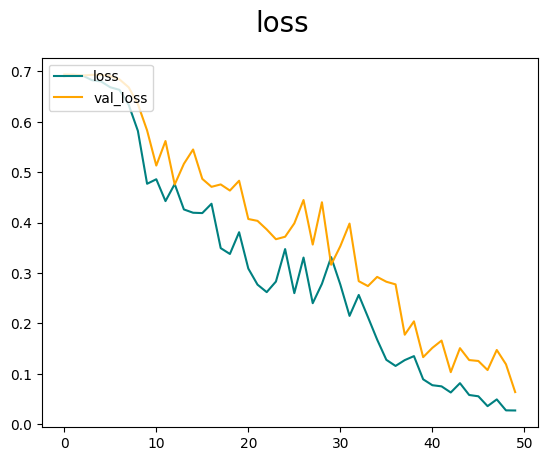

In [ ]:
#loss graph
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

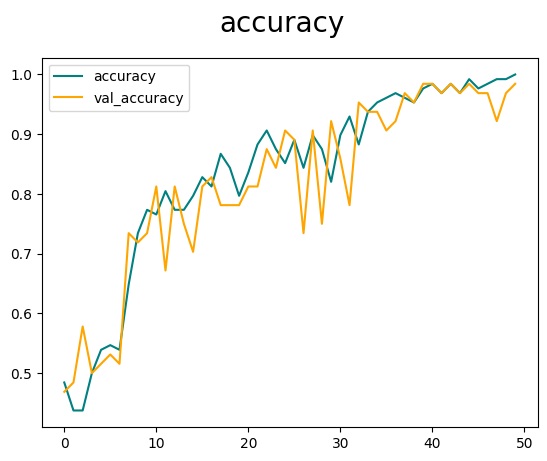

In [ ]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

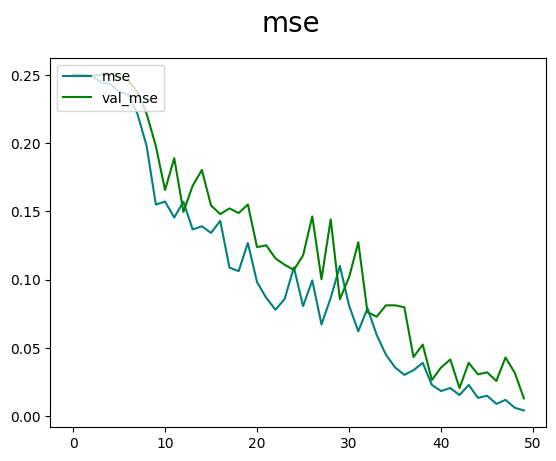

In [ ]:
#mse
fig = plt.figure()
plt.plot(history.history['mse'], color='teal', label='mse')
plt.plot(history.history['val_mse'], color='green', label='val_mse')
fig.suptitle('mse', fontsize=20)
plt.legend(loc='upper left')
plt.show()

##Evaluate Performance


In [ ]:
# Evaluate the model with the test data, for get the values of accuracy, loss and mse
loss, accuracy, mse = model.evaluate(test)

1/1 [==============================] - 2s 2s/step - loss: 0.0494 - accuracy: 1.0000 - mse: 0.0058


In [ ]:
# Do the Predictions with the test Data
y_pred = model.predict(test)

1/1 [==============================] - 4s 4s/step


In [ ]:
# Arredondar as previsoes para 0 ou 1, de acordo com os nosso targets
y_predictions_classifier =[]
for d in y_pred:
  if d > 0.5:
    y_predictions_classifier.append(1)
  else:
    y_predictions_classifier.append(0)
# print preditions
y_predictions_classifier

[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]

In [ ]:
# Get a list with the values of the data test targets
labels_list = []
for batch in test.as_numpy_iterator():
    X, y = batch
    labels_list.extend(y.tolist())

# print the target list of test data
print(labels_list)


[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
# Mostrar todas as metricas de acordo com as previsoes efetuadas pelo modelo
report = classification_report(labels_list, y_pred=y_predictions_classifier, digits= 4, target_names=['clean','littered'])
print(report)

              precision    recall  f1-score   support

       clean     0.5000    0.5714    0.5333         7
    littered     0.5714    0.5000    0.5333         8

    accuracy                         0.5333        15
   macro avg     0.5357    0.5357    0.5333        15
weighted avg     0.5381    0.5333    0.5333        15



In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 90ms/step


In [ ]:
# print the metrics
# Obter os resultados finais das métricas
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
print("Precision:", precision_result)
print("Recall:", recall_result)
print("Binary Accuracy:", accuracy_result)

Precision: 0.9
Recall: 1.0
Binary Accuracy: 0.93333334


In [ ]:
#upload a Littered road
files.upload()
print()

Saving clean.jpeg to clean (1).jpeg



In [ ]:
def show_image(name):
  img = cv2.imread(name)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  return img

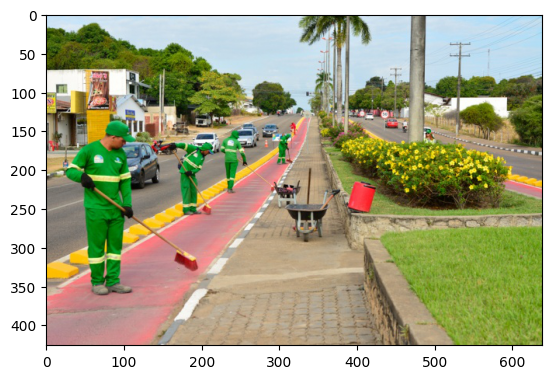

In [ ]:
# teste for the clean image
# chose one image at time for the test
img = show_image('clean.jpeg')

In [ ]:
# teste for the dirty image
img = show_image('dirty.jpeg')

In [ ]:
# resize the image
resize = tf.image.resize(img, (256,256))

In [ ]:
#predict
np.expand_dims(resize, 0) #put in a list

yhat = model.predict(np.expand_dims(resize/255,0))

if yhat > 0.5:
  print('The road is dirty')
else:
  print('the road is clean')

1/1 [==============================] - 0s 105ms/step
the road is clean


# Teste the model with the grey_scaler

### Train

Call the model creatin and start the training

In [ ]:
# define the model and pass the number of channels, in this case, they is 1 because this is a greyscale image
 # Call the functions and show the model summary
# this summary is important because we see how the convolutional layer is behaving
model = create_conv2d(1)
model_grey = define_metrics(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 32)       

In [ ]:
history = model_grey.fit(train_grey, epochs=50, validation_data=val_grey, validation_batch_size=16, callbacks=callback_list)

Epoch 1/50
4/4 [==============================] - 8s 1s/step - loss: 4.3641 - accuracy: 0.4375 - mse: 0.4600 - val_loss: 0.7490 - val_accuracy: 0.5156 - val_mse: 0.2761
Epoch 2/50
4/4 [==============================] - 5s 879ms/step - loss: 1.6000 - accuracy: 0.4688 - mse: 0.4412 - val_loss: 0.6934 - val_accuracy: 0.4844 - val_mse: 0.2501
Epoch 3/50
4/4 [==============================] - 5s 851ms/step - loss: 0.6956 - accuracy: 0.5234 - mse: 0.2511 - val_loss: 0.6931 - val_accuracy: 0.5312 - val_mse: 0.2500
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 0.7042 - accuracy: 0.4844 - mse: 0.2556 - val_loss: 0.6931 - val_accuracy: 0.5156 - val_mse: 0.2500
Epoch 5/50
4/4 [==============================] - 5s 870ms/step - loss: 0.6853 - accuracy: 0.5234 - mse: 0.2462 - val_loss: 0.6932 - val_accuracy: 0.4844 - val_mse: 0.2500
Epoch 6/50
4/4 [==============================] - 9s 2s/step - loss: 0.6836 - accuracy: 0.5078 - mse: 0.2453 - val_loss: 0.6930 - val_accuracy: 0.

In [ ]:
# see all the values
# loss, accuracy, val_loss,val_accuracy
history.history

{'loss': [4.364126205444336,
  1.5999878644943237,
  0.6956246495246887,
  0.7041714787483215,
  0.6853418350219727,
  0.6835811138153076,
  0.6776373982429504,
  0.679116427898407,
  0.681903600692749,
  0.6878523826599121,
  0.6848145127296448,
  0.663905143737793,
  0.671794056892395,
  0.6596635580062866,
  0.6619642972946167,
  0.6300482749938965,
  0.6125118732452393,
  0.5616225004196167,
  0.5233629941940308,
  0.5955891609191895,
  0.5267727375030518,
  0.5389454364776611,
  0.47991567850112915,
  0.5084644556045532,
  0.47318369150161743,
  0.5061891078948975,
  0.47918903827667236,
  0.44243544340133667,
  0.4322320818901062,
  0.4559938609600067,
  0.3966990113258362,
  0.4185154438018799,
  0.4289822578430176,
  0.417487233877182,
  0.4167850613594055,
  0.374041348695755],
 'accuracy': [0.4375,
  0.46875,
  0.5234375,
  0.484375,
  0.5234375,
  0.5078125,
  0.546875,
  0.5390625,
  0.515625,
  0.46875,
  0.484375,
  0.5859375,
  0.5390625,
  0.5546875,
  0.5390625,
  0.67

## Show the resuls

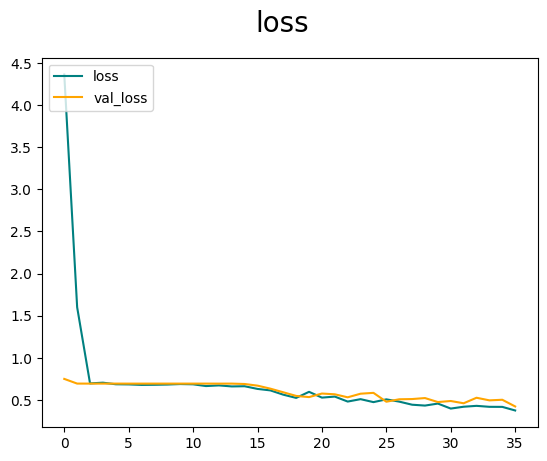

In [ ]:
#loss graph
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

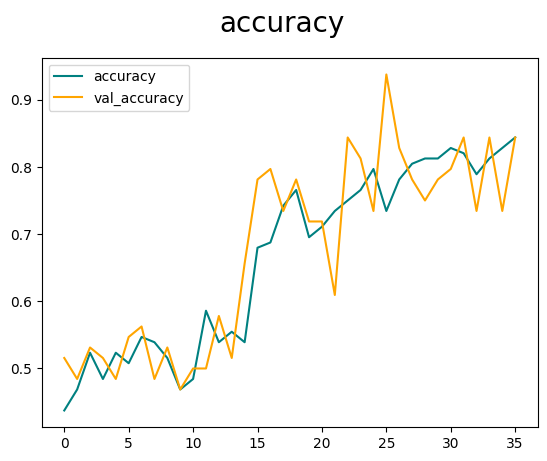

In [ ]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

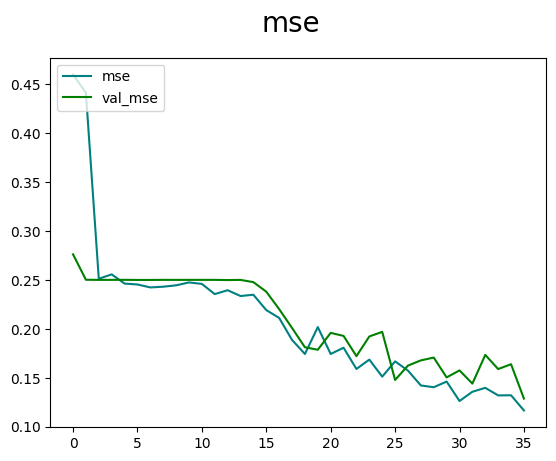

In [ ]:
#mse
fig = plt.figure()
plt.plot(history.history['mse'], color='teal', label='mse')
plt.plot(history.history['val_mse'], color='green', label='val_mse')
fig.suptitle('mse', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate Performance


In [ ]:
# Evaluate the model with the test data, for get the values of accuracy, loss and mse
loss, accuracy, mse = model_grey.evaluate(test_grey)

1/1 [==============================] - 2s 2s/step - loss: 0.3830 - accuracy: 0.8667 - mse: 0.1107


In [ ]:
# Do the Predictions with the test Data
y_pred_grey = model_grey.predict(test_grey)

1/1 [==============================] - 3s 3s/step


In [ ]:
# Arredondar as previsoes para 0 ou 1, de acordo com os nosso targets
y_predictions_classifier_grey =[]
for d in y_pred_grey:
  if d > 0.5:
    y_predictions_classifier_grey.append(1)
  else:
    y_predictions_classifier_grey.append(0)
# print preditions
y_predictions_classifier_grey

[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]

In [ ]:
# Get a list with the values of the data test targets
labels_list = []
for batch in test_grey.as_numpy_iterator():
    X, y = batch
    labels_list.extend(y.tolist())

# print the target list of test data
print(labels_list)


[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1]


In [ ]:
# Mostrar todas as metricas de acordo com as previsoes efetuadas pelo modelo
report = classification_report(labels_list, y_pred=y_predictions_classifier_grey, digits= 4, target_names=['clean','littered'])
print(report)

              precision    recall  f1-score   support

       clean     0.4000    0.5000    0.4444         8
    littered     0.2000    0.1429    0.1667         7

    accuracy                         0.3333        15
   macro avg     0.3000    0.3214    0.3056        15
weighted avg     0.3067    0.3333    0.3148        15



In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test_grey.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 87ms/step


In [ ]:
# print the metrics
# Obter os resultados finais das métricas
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
print("Precision:", precision_result)
print("Recall:", recall_result)
print("Binary Accuracy:", accuracy_result)

Precision: 0.6666667
Recall: 0.85714287
Binary Accuracy: 0.73333335


# Test with data_argumentation

### Train

In [ ]:
# define the model and pass the number of channels, in this case they are 3
#Call the functions and show the model summary
# this summary is importan because we see how the convulational layer is behaving
model = create_conv2d(3)
model_aug = define_metrics(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 32)       

train the model

In [ ]:
history = model_aug.fit(train_data_aug, epochs=50, validation_data=val, validation_batch_size=8, callbacks=callback_list)

Epoch 1/50
4/4 [==============================] - 18s 3s/step - loss: 0.6964 - accuracy: 0.4375 - mse: 0.2516 - val_loss: 0.8023 - val_accuracy: 0.5000 - val_mse: 0.2986
Epoch 2/50
4/4 [==============================] - 15s 3s/step - loss: 0.6932 - accuracy: 0.5078 - mse: 0.2500 - val_loss: 0.6839 - val_accuracy: 0.5781 - val_mse: 0.2454
Epoch 3/50
4/4 [==============================] - 15s 3s/step - loss: 0.6932 - accuracy: 0.4922 - mse: 0.2500 - val_loss: 0.6589 - val_accuracy: 0.6562 - val_mse: 0.2330
Epoch 4/50
4/4 [==============================] - 16s 4s/step - loss: 0.6926 - accuracy: 0.5625 - mse: 0.2497 - val_loss: 0.6917 - val_accuracy: 0.5625 - val_mse: 0.2491
Epoch 5/50
4/4 [==============================] - 15s 3s/step - loss: 0.6925 - accuracy: 0.5312 - mse: 0.2497 - val_loss: 0.6580 - val_accuracy: 0.5938 - val_mse: 0.2327
Epoch 6/50
4/4 [==============================] - 17s 4s/step - loss: 0.6933 - accuracy: 0.5156 - mse: 0.2501 - val_loss: 0.6866 - val_accuracy: 0.468

## Show Results

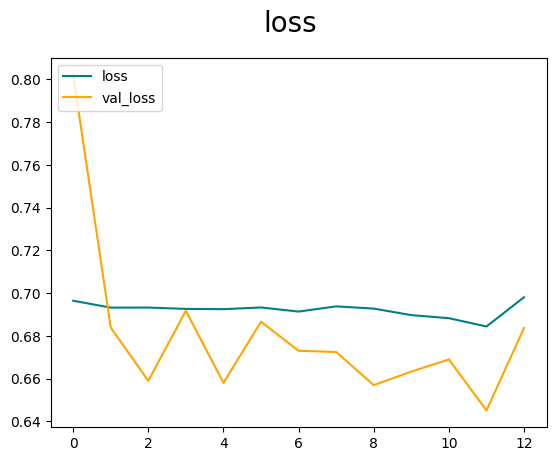

In [ ]:
#loss graph
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

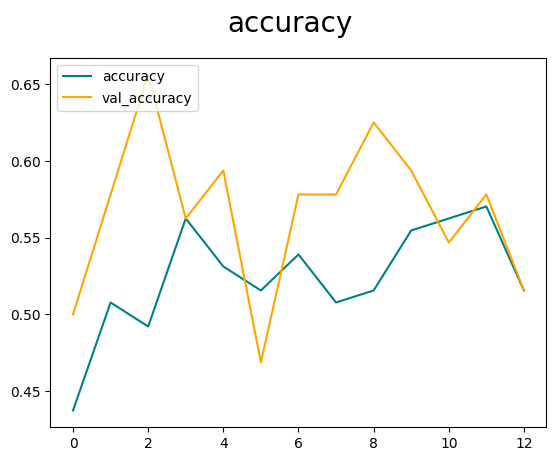

In [ ]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

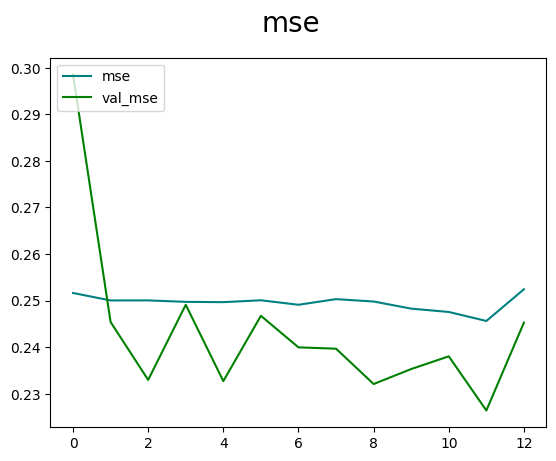

In [ ]:
#mse
fig = plt.figure()
plt.plot(history.history['mse'], color='teal', label='mse')
plt.plot(history.history['val_mse'], color='green', label='val_mse')
fig.suptitle('mse', fontsize=20)
plt.legend(loc='upper left')
plt.show()

##Evaluate Performance


In [ ]:
# Evaluate the model with the test data, for get the values of accuracy, loss and mse
loss, accuracy, mse = model.evaluate(test)

1/1 [==============================] - 3s 3s/step - loss: 2.0706 - accuracy: 0.5333 - mse: 0.4542


In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 377ms/step


In [ ]:
# print the metrics
# Obter os resultados finais das métricas
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
print("Precision:", precision_result)
print("Recall:", recall_result)
print("Binary Accuracy:", accuracy_result)

Precision: 0.5714286
Recall: 0.8888889
Binary Accuracy: 0.53333336


# Conclusion

## About the First model


This model trained for 50 epochs, and a callback was added to stop training whenever there was no improvement in “val_accuracy” for 10 epochs. By observing the graphs, we obtain curves that are not very smooth, with some peaks in the data, however, we realize that both validation and training go hand in hand. As for loss and val_loss, they continue to fall throughout the 50 epochs, until values close to zero, however, loss, close to epoch 50, begins to stabilize while val_loss continues to fall after a peak. In accuracy, as expected because it demonstrates the opposite of loss, the curve is also not linear, it has many ups and downs, and many peaks, it increases to the value 1, during the 50 epochs. If it weren't for the ups and downs of the curves, we could be looking at a very good result, or a misleading result, as the model could have “memorized the training data. In the mse graph, we obtain behavior and a graph very similar to that obtained in loss, without the part of stabilizing the mse close to epoch 50. We were able to obtain an evaluation on the test data of 0.050 loss, 0.0058 mse, and 1.0 accuracy. However, when we do more tests we obtain a binary accuracy of 0.93 and a precision of 0.9. As for the test to classify a new image, where we load this image, we get the desired answer, we load an image with a clean street and the model classifies it as clean.



## About the model with the grey_scaler

In the test with gray scale images, we obtain different graphs, namely the loss which, despite being linear, without peaks, drops sharply in the first iterations but continues to decrease, very smoothly, throughout the 35 iterations.
In accuracy we obtain a graph with the same format as the previous test, containing many inconsistent values in the validation data.
As for mse, it starts to drop drastically in the first iterations, and during the remaining epochs, it continues to decrease, but more smoothly along with mse_val.
In this test we obtain an accuracy of 0.87 and a loss of 0.38, that is, worse values than those obtained in the previous test.
A Binary accuracy of 0.73 and a precision of 0.66 were obtained, which is also lower than the results obtained in the previous model.
It was decided to carry out a test with gray tone images, just one color channel, as the model could have an easier time dealing with the input data and obtain better results, however, based on the numbers observed, this was not the result. expected.


## About the Test whit data_argumentation

Finally, an approach was taken and a test was carried out, the results were not as expected, however, we can use this “almost failed” test to understand that even a good approach needs to be well implemented with the right parameters.
We use “data augmentation” to “generate” images in the training dataset and thus allow us to “increase” our dataset. The result was much lower than expected, as we can see from the graphs obtained, where we obtained curves that were not very easy to interpret and not very normal.
This test trained for 13 epochs, the callback was called and finished training and obtained a Binary accuracy of 0.53 and a precision of 0.57.
We can conclude that, although the approach is good and applicable in cases where we have few training images, it did not obtain better results than the first model.
Problems in the implementation and parameters selected for this approach may be the cause of this poor result. More time would be needed to better analyze and test the parameters and implementations of this approach.


## Tasks that could improve performance

- With these tests, we can conclude that we can improve the model's performance, use other techniques to process the images, or also, something that could be very important in this case, would be to increase the dataset to contain more images and have more data to train.
We can mention that:
- We could have better results if the dataset contained a greater number of data, as at the moment we were only working with just over 207 images.
- Experiment with new metrics, and new parameters, making a much more intensive adjustment to the parameters used for training and creating the convulsive layer.
- Use data visualization techniques, in addition to graphs, to help understand where the model may need further adjustments.
- Better understanding of how to implement and improve the parameters of techniques that deal with datasets with little training data.

However, all of these approaches were not possible to fully put into practice, only in a more gentle way, as the model still needs some time to process the data and make predictions. To make a super adjustment of parameters would take a lot of time.
